# Introduction

## Imports

In [1]:
import pandas as pd

import numpy as np

import os

In [2]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Data info

In [3]:
for file in os.listdir('../data/'):
    print(file + '\t\t\t\t\t\t' + str(os.stat("../data/" + file).st_size/1000000))

auctions.csv						2412.11824
.ipynb_checkpoints						0.004096
target_competencia_ids.csv						0.200915
installs.csv						123.502317
desc.json						0.009146
Recomendaciones y aclaraciones.docx						0.006909
clicks.csv						16.147446
events.csv						2252.988966


# Useful functions

## General

In [4]:
# days to consider
all_days = [18,19,20,21,22,23,24,25,26]

In [5]:
def get_n_3_days(n):
    """
    get nth block of 3 consecutive days
    n can go from 1 to 7.
    If n == 8, then last two days are given.
    If n == 9, then last day is given.
    """
    n -= 1
    return all_days[n:n+3]

### Target related

In [6]:
# load target
def load_target():
    target = pd.read_csv('../data/target_competencia_ids.csv')

    # to avoid misunderstandings with data when predicting, and avoid accidentally predicting value zero
#     target.obj = np.nan
    
    return target

# para que quede cargado desde el principio
target = load_target()

# target ids related
def get_target_ids():
    """ get all target ids """
    return target['ref_hash'].apply(lambda x: x[:-3]).unique()

def get_target_ids_chunk(chunk_num):
    """ chunk num can go from 1 to 41 """
    chunk_size = 100
    start = (chunk_num - 1) * chunk_size
    stop = chunk_size * chunk_num
    return get_target_ids()[start:stop]

### Predictions related

In [7]:
# para guardar predicciones
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="mati", description = "no description"):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=False)
    _save_description(authors_name, timestamp, description)

In [8]:
def store_predictions(target_df, new_values, value_column_name, suffix):
    """
    adds predictions from value_column_name from new_values df
    to target_df merging by ref_hash and the given suffix 
    suffix: "_st" for auction prediction
            "_sc" for conversion prediction
    """
    new_values['ref_hash'] = new_values['ref_hash'] + suffix
    
    target_df = target_df.merge(new_values[['ref_hash',value_column_name]], how='left', on='ref_hash')
    
    target_df.fillna(0, inplace=True)
    
#     assign values to 'obj' column and remove the column added on merge.
#     after sum, fillna is needed because there are values which are left as NaNs.
    target_df['obj'] = target_df['obj'] + target_df[value_column_name]
    
    target_df.drop([value_column_name], axis='columns', inplace=True)
    return target_df

In [9]:
# play a sound
import os
def ring(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

## Dfs loading functions

### Clicks

In [25]:
cols = ['source_id','created','latitude','longitude','wifi_connection',
        'carrier_id','os_minor','os_major','specs_brand','timeToClick',
        'touchX','touchY','ref_type','ref_hash',]

clicks_dtypes = {
#     'advertiser_id':'category',
#                  'action_id':'category',
                 'source_id':'category',
#                  'country_code':'category',
                 'latitude':'float64',
                 'longitude':'float64',
                 'wifi_connection':'bool',
                 'carrier_id':'category',
#                  'trans_id':'category',
                 'os_minor':'category',
#                  'agent_device':'category',
                 'os_major':'category',
                 'specs_brand':'category',
#                  'brand':'category',
                 'timeToClick':'float64',
                 'touchX':'object',
                 'touchY':'object',
                 'ref_type':'category',
                 'ref_hash':'category'}

def load_clicks(users=get_target_ids(), days=all_days):
    """
    load clicks csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively.
    """
    
    df_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], usecols=cols)
    
    def load_condition(chunk):
        return chunk['ref_hash'].isin(users) & chunk['created'].dt.day.isin(days)
    
    df = df_clicks.loc[load_condition(df_clicks)].copy()
    
    df.rename(columns={'created':'date'}, inplace=True)
    
    df['date'] = df['date'].dt.tz_localize(None)
    
    return df

### Installs

In [26]:
cols = ['created','application_id','ref_hash','attributed','implicit','device_brand','device_model','session_user_agent','device_language']

installs_dtypes = {"application_id":          "category",
#                    "ref_type":                "category",
                   "ref_hash":                "object",
#                    "click_hash":             "category",
                   "attributed":               "bool",
                   "implicit":                 "bool",
#                    "device_countrycode":      "category",
                   "device_brand":          "category",
                   "device_model":          "category",
                   "session_user_agent":     "category",
#                    "user_agent":             "category",
#                    "event_uuid":             "category",
#                    "kind":                   "category",
#                    "wifi":                   "category",
#                    "trans_id":               "category",
#                    "ip_address":              "category",
                   "device_language":       "category"}

def load_installs(users=get_target_ids(), days=all_days):
    """
    load installs csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively.
    """
    
    df_installs = pd.read_csv('../data/installs.csv', engine='c', dtype=installs_dtypes, parse_dates=['created'], usecols=cols)
    
    def load_condition(df):
        return df['ref_hash'].isin(users) & df['created'].dt.day.isin(days)
    
    df = df_installs.loc[load_condition(df_installs)].copy()
    
    df.rename(columns={'created':'date'}, inplace=True)
    
    return df

### Events

In [27]:
cols = ['date','ref_hash','application_id','attributed','device_model','ip_address']

events_dtypes = {
#     "index":                   "category",
#                  "event_id":                "category",
#                  "ref_type":                "category",
                 "ref_hash":                "category",
                 "application_id":          "category",
                 "attributed":               "bool",
#                  "device_countrycode":      "category",
#                  "device_os_version":     "category",
#                  "device_brand":          "category",
                 "device_model":          "category",
#                  "device_city":           "category",
#                  "session_user_agent":    "category",
#                  "trans_id":               "category",
#                  "user_agent":            "category",
#                  "event_uuid":             "category",
#                  "carrier":               "category",
#                  "kind":                  "category",
#                  "device_os":             "category",
#                  "wifi":                     "bool",
#                  "connection_type":        "category",
                 "ip_address":              "category",
#                  "device_language":       "category"
}

def load_events(users=get_target_ids(), days=all_days):
    """
    load events csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively.
    """
    
    iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000, usecols=cols)
    
    def load_condition(chunk):
        return chunk['ref_hash'].isin(users) & chunk['date'].dt.day.isin(days)
    
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_events)
    
    return df

### Auctions

In [13]:
auctions_dtypes = {'device_id':'category',
                 'ref_type_id':'category',
                 'source_id':'category'}

def load_auctions(users=get_target_ids(), days=all_days):
    """ load auctions csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively."""
    iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
    def load_condition(chunk):
        return chunk['device_id'].isin(users) & chunk['date'].dt.day.isin(days)
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_auctions)
    
    df.rename(columns={'device_id':'ref_hash'}, inplace=True)
    
    return df

# Recommended bibliography

- [Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA): Introduction to survival analysis and the lifelines lib in python. Shows simple example (aka, theres code!!)
- [Tristan Boudreault | Survival analysis for conversion rates](https://www.youtube.com/watch?v=oui1hx2bM2o): Estudio de caso: Shopify. From pyData conference in Amsterdam
- [Introduction to survival analysis](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis): by lifelines

#### Pseudo resumen de cosas utiles para aplicar
Para survival analysis se necesitan dos cosas:
- an array of durations
- either a boolean or binary array representing whether the “death” was observed or not (alternatively an individual can be censored).

# Un vistazo sobre los dfs

## Clicks

In [136]:
df = load_clicks(get_target_ids_chunk(1), all_days[:3])

In [137]:
df.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
11899,2,NaN,1,2019-04-20 04:23:39.214000+00:00,6287817205707153877,1.771786,0.850556,True,1.0,2erPcX11IzP-xXiSiUTEOtMKiIKd9lQ,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,NaN,NaN,NaN,1891515180541284343,1102680423242413676
11922,2,NaN,1,2019-04-20 04:30:28.785000+00:00,6287817205707153877,1.771786,0.850556,True,1.0,xXnQL1gGPzqGs-BFn45NS9i5gkZsIqU,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,403.314,0.933,1.093,1891515180541284343,1102680423242413676
25085,2,NaN,1,2019-04-18 16:55:31.227000+00:00,6287817205707153877,1.791655,0.855685,True,1.0,2nebL7UP8AoozSeLGQW1p6f78TATevg,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,115.522,0.579,1.407,1891515180541284343,1102680423242413676
61291,1,NaN,1,2019-04-20 19:53:18.984000+00:00,6287817205707153877,1.714538,0.871000,False,11.0,pXaVgJhWiXXTvNY3H0OgmA5V1HOjmWI,1.5176438893491397e+18,NaN,5.131615556736863e+18,71913840936116953,NaN,0.838,0.118,0.020,1891515180541284343,1058525390691423513
63806,1,NaN,1,2019-04-19 12:46:43.763000+00:00,6287817205707153877,1.713614,0.870279,True,1.0,-USvZQZBbN-CmUmaxwghWUUJA1dNnx4,1.5176438893491397e+18,NaN,5.131615556736863e+18,71913840936116953,NaN,17.752,0.359,1.247,1891515180541284343,1058525390691423513


## Installs

In [141]:
df = load_installs(get_target_ids_chunk(1), all_days[:3])

In [142]:
df.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
7016,2019-04-19 02:37:34.033,14,1891515180541284343,1128814228344083814,NaN,False,False,6287817205707153877,2.208834667126999e+18,4.445013666528814e+18,NaN,NaN,NaN,NaN,NaN,NaN,2514363106721953847,3.3013777759776993e+18
7022,2019-04-19 02:37:34.101,14,1891515180541284343,1128814228344083814,NaN,False,True,6287817205707153877,2.208834667126999e+18,4.445013666528814e+18,HasOffers Mobile AppTracking v1.0,NaN,f4714013-b8aa-415e-aa58-fa98ebf64d23,Open,NaN,NaN,2514363106721953847,3.3013777759776993e+18
28381,2019-04-18 22:23:29.656,49,1494519392962156891,1048782984015604883,NaN,False,True,6287817205707153877,NaN,6.794880020077885e+18,http-kit/2.0,SinDelantal/1 CFNetwork/976 Darwin/18.2.0,834549e2-52f8-4d83-afd5-4dace2a4c50d,af_app_opened,true,NaN,7869038058745259581,8.441417429938962e+18
48676,2019-04-20 12:35:20.625,77,1891515180541284343,1054881396892383323,NaN,False,False,6287817205707153877,NaN,1.3445980799392305e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,154615607683715141,4.060929664968129e+18
50673,2019-04-20 02:31:26.269,78,1891515180541284343,1010265377387765028,NaN,False,False,6287817205707153877,6.115025880051902e+18,1.670346184923358e+18,http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.1.0; JKM-LX3...,NaN,NaN,true,NaN,9101982838620332898,6.977049253562486e+18


## Events

In [143]:
df = load_events(get_target_ids_chunk(1), all_days[:3])

In [144]:
df.head()

,index,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,...,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language
170519,177561,2019-04-18 03:43:09.185,13,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,...,NaN,4.0670089932515717e+18,a27f9076-4e31-42a4-8e28-bcf17e58fa98,NaN,4.853173252142275e+18,NaN,True,NaN,7209709704711395089,6.977049253562486e+18
170521,177563,2019-04-18 03:43:25.436,13,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,...,NaN,4.0670089932515717e+18,ad49682d-5bd2-47b4-aaaa-6196ac417503,NaN,4.853173252142275e+18,NaN,True,NaN,7209709704711395089,6.977049253562486e+18
170525,177577,2019-04-18 03:43:21.320,13,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,...,NaN,4.0670089932515717e+18,1e67b319-e2dd-4ac9-b6e6-879576320bd8,NaN,4.853173252142275e+18,NaN,True,NaN,7209709704711395089,6.977049253562486e+18
170529,177589,2019-04-18 03:43:08.996,13,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,...,NaN,4.0670089932515717e+18,44e56660-8642-4541-8724-5a1503c23542,NaN,4.853173252142275e+18,NaN,True,NaN,7209709704711395089,6.977049253562486e+18
171835,180801,2019-04-19 17:01:38.181,15,1891515180541284343,1117811498061299916,65,False,6287817205707153877,NaN,2.208834667126999e+18,...,NaN,8.237820697921044e+18,ce425a21-4271-4b8f-89cb-371e67a128c5,NaN,5.500848327478996e+18,NaN,True,NaN,3382054713307838865,6.977049253562486e+18


## Auctions

In [147]:
df = load_auctions(get_target_ids_chunk(1), all_days[:3])

In [148]:
df.head()

,date,device_id,ref_type_id,source_id
289649,2019-04-18 19:58:47.826462,1114026657194419748,1,0
317697,2019-04-18 23:34:28.216676,1102680423242413676,1,1
317713,2019-04-18 23:34:36.035822,1102680423242413676,1,1
317978,2019-04-18 23:42:35.347774,1102680423242413676,1,1
318297,2019-04-18 23:44:54.822177,1102680423242413676,1,1


# ML

In [14]:
def set_source_col(df, source):
    """
    for a given dataframe, create a column indicating
    from which csv file it originated
    """
    df['source_csv'] = source

def process_time_diffs(df):
    """
    create column indicating difference between two
    consecutive registers for each device id
    """
    asdf = df
    
    asdf = asdf.sort_values(['date'])
    
    asdf['diff'] = asdf.groupby(['ref_hash'])['date'].diff()

    asdf['diff'].fillna(value=asdf['date']-asdf['date'].dt.floor('d'), inplace=True)

    asdf['diff_in_sec'] = asdf['diff'].dt.total_seconds()

    asdf.drop('diff', axis='columns', inplace=True)
    
    return asdf

def process_time_diffs_vs_min_day(df):
    """
    create column indicating difference between
    time in registers and min day in df
    """
    asdf = df

    min_timestamp = asdf['date'].min().floor('d')

    asdf['diff'] = asdf['date'] - min_timestamp

    asdf['diff_in_sec'] = asdf['diff'].dt.total_seconds()

    asdf.drop('diff', axis='columns', inplace=True)
    
    return asdf


def set_observed_column(df, csv_source_that_defines_death, inplace=False):
    """
    create column indicating if death has been observed or not.
    """
    asdf = df
    
    asdf['observed'] = asdf.source_csv == csv_source_that_defines_death
    
    return asdf

***

## Approach 1: mean value per device

### Auctions

In [48]:
df_auctions = load_auctions()

df_auctions2 = process_time_diffs(df_auctions)

current_predictions = df_auctions2.groupby('ref_hash', as_index=False)[['diff_in_sec']].mean()

target = store_predictions(target_df=target, new_values=current_predictions, value_column_name='diff_in_sec', suffix='_st')

In [49]:
del df_auctions
del df_auctions2

### Installs

In [51]:
df_installs = load_installs()

df_installs2 = process_time_diffs(df_installs)

current_predictions = df_installs2[['ref_hash','diff_in_sec']].groupby('ref_hash', as_index=False).mean()

target = store_predictions(target_df=target, new_values=current_predictions, value_column_name='diff_in_sec', suffix='_sc')

In [50]:
del df_installs
del df_installs2

***

In [57]:
save_submission(target, description="por cada grupo, avg. de los tiempos entre cada registro.")

## End of Approach 1: mean value per device

***

## Approach 2: mean value per device taking time from one common start

### Auctions

In [15]:
df_auctions = load_auctions(days=get_n_3_days(1))

df_auctions2 = process_time_diffs_vs_min_day(df_auctions)

current_predictions = df_auctions2.groupby('ref_hash', as_index=False)[['diff_in_sec']].mean()

target = store_predictions(target_df=target, new_values=current_predictions, value_column_name='diff_in_sec', suffix='_st')

In [16]:
del df_auctions
del df_auctions2

### Installs

In [17]:
df_installs = load_installs(days=get_n_3_days(1))

df_installs2 = process_time_diffs_vs_min_day(df_installs)

current_predictions = df_installs2[['ref_hash','diff_in_sec']].groupby('ref_hash', as_index=False).mean()

target = store_predictions(target_df=target, new_values=current_predictions, value_column_name='diff_in_sec', suffix='_sc')

In [18]:
del df_installs
del df_installs2

***

In [19]:
save_submission(target, description="por cada grupo, avg. de los tiempos tomados a partir del primer dia de los elegidos.")

## End of Approach 2: mean value per device taking time from one common start

***

## Approach 3:

### Define current users/days

In [15]:
current_users = get_target_ids_chunk(1)
current_days = [24,25]

In [16]:
df_clicks = load_clicks(current_users, current_days)
df_installs = load_installs(current_users, current_days)
df_events = load_events(current_users, current_days)
df_auctions = load_auctions(current_users, current_days)

In [17]:
print(df_clicks.memory_usage(deep=True).sum()/1e6)
print(df_installs.memory_usage(deep=True).sum()/1e6)
print(df_events.memory_usage(deep=True).sum()/1e6)
print(df_auctions.memory_usage(deep=True).sum()/1e6)

12.062855
52.20738
0.422809
0.465788


### Calculate time diffs per ref hash

In [18]:
df_clicks = process_time_diffs(df_clicks)
df_installs = process_time_diffs(df_installs)
df_events = process_time_diffs(df_events)
df_auctions = process_time_diffs(df_auctions)

In [19]:
df_clicks.head()

,advertiser_id,action_id,source_id,date,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash,diff_in_sec
26073,2,NaN,1,2019-04-25 05:14:11.091,6287817205707153877,1.735196,0.861823,False,2.0,6kZO7SzDHbfr7-ykA3k6WUGdKZm6MQo,5.138422321014424e+18,6.794880020077885e+18,8.310800446698691e+18,71913840936116953,NaN,23.796,0.453,1.947,1494519392962156891,109389620877102250,18851.091
23016,2,NaN,1,2019-04-25 14:01:48.985,6287817205707153877,1.791432,0.855503,True,1.0,zpgPQlIudjkzMVBmYtjgR4Ni9jKkhBc,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,NaN,NaN,NaN,1891515180541284343,1102680423242413676,50508.985


In [20]:
df_installs.head()

,date,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,diff_in_sec
477685,2019-04-24 02:50:31.898,122,1891515180541284343,111177788438165194,NaN,False,False,6287817205707153877,NaN,2.544397034501987e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,7830111374649583887,3.3013777759776993e+18,10231.898
104143,2019-04-24 03:02:17.657,116,1494519392962156891,1017958004932387739,NaN,False,False,6287817205707153877,NaN,6.140637470197822e+18,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like...,NaN,NaN,NaN,NaN,NaN,5603295048032031059,3.3013777759776993e+18,10937.657
161897,2019-04-24 04:27:51.320,161,1891515180541284343,1098333517628887771,NaN,False,True,6287817205707153877,4.567867128441484e+18,9.176732026267037e+18,http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; Z815 Bu...,d79c3fdc-4a91-4282-87df-39ef2b772507,APP_ALIVE,true,NaN,2793879629060600395,6.977049253562486e+18,16071.320
163272,2019-04-24 04:45:34.346,165,1494519392962156891,1118296407046663101,NaN,False,False,6287817205707153877,NaN,1.6233691811036398e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,625930415639700335,3.3013777759776993e+18,17134.346
405792,2019-04-24 13:37:13.659,323,1494519392962156891,1021582875881379650,NaN,False,True,6287817205707153877,NaN,4.322425952775763e+18,adjust.com,NaN,21bb8aa6-84e0-4aa8-8cda-c15470962d4b,app_open,NaN,NaN,5269848494381674859,3.3013777759776993e+18,49033.659


In [21]:
df_events.head()

,index,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,device_model,device_city,session_user_agent,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language,diff_in_sec
4581417,64698,2019-04-24 00:08:16.270,15,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,5.186986602616849e+18,NaN,3.819516403548394e+18,NaN,4.0670089932515717e+18,8dcd8d79-0a87-4322-b807-ab6145e2526d,NaN,5.500848327478996e+18,NaN,True,NaN,2842424955933477545,6.977049253562486e+18,496.270
3662315,191584,2019-04-24 01:15:45.789,23,1891515180541284343,1070673984959261173,155,False,6287817205707153877,2.85370396744477e+18,NaN,3.956062879335487e+18,NaN,4.3590463133238523e+18,NaN,NaN,1800c2e4-8d4e-4720-a48f-d568bef924e5,NaN,6.081164526912919e+18,NaN,False,NaN,6307026649410023867,3.3013777759776993e+18,4545.789
6436964,98672,2019-04-24 01:21:30.182,108,1891515180541284343,1070673984959261173,155,False,6287817205707153877,2.85370396744477e+18,NaN,3.956062879335487e+18,NaN,4.3590463133238523e+18,NaN,NaN,4ecf513b-98f9-4901-9cc9-a192b0b4400d,NaN,2.3767496212528297e+18,NaN,False,NaN,6307026649410023867,3.3013777759776993e+18,344.393
6259767,94162,2019-04-24 02:35:42.355,15,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,5.186986602616849e+18,NaN,3.819516403548394e+18,NaN,4.0670089932515717e+18,e242c737-eade-4880-95da-c95b25954f3c,NaN,5.500848327478996e+18,NaN,True,NaN,2842424955933477545,6.977049253562486e+18,8846.085
147753,68065,2019-04-24 02:37:32.500,13,1891515180541284343,1106971792117053344,65,False,6287817205707153877,NaN,2.208834667126999e+18,5.186986602616849e+18,NaN,3.819516403548394e+18,NaN,4.0670089932515717e+18,7aa99e45-02e5-4d27-a436-2b596cd8b812,NaN,4.853173252142275e+18,NaN,True,NaN,2842424955933477545,6.977049253562486e+18,110.145


In [22]:
df_auctions.head()

,date,ref_hash,ref_type_id,source_id,diff_in_sec
7800107,2019-04-24 00:00:23.704470,1071701264087131067,1,1,23.704470
4469595,2019-04-24 00:01:17.582069,1160971248791325717,1,1,77.582069
33411545,2019-04-24 00:03:28.912509,1014428234021750342,7,1,208.912509
20798098,2019-04-24 00:09:23.103552,1053399148291039201,1,2,563.103552
43046841,2019-04-24 00:09:31.999520,1030603044158081433,1,1,571.999520


In [23]:
ring()

### Append 'em!

In [22]:
set_source_col(df_clicks, "clicks")
set_source_col(df_installs, "installs")
set_source_col(df_events, "events")
set_source_col(df_auctions, "auctions")

In [23]:
appended = df_clicks.append(df_installs, sort=False).append(df_events, sort=False).append(df_auctions, sort=False)

# appended.sort_values(['date'], inplace=True)

In [24]:
appended.head()

,advertiser_id,action_id,source_id,date,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash,diff_in_sec,source_csv,application_id,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,ip_address,device_language,index,event_id,device_os_version,device_city,carrier,device_os,connection_type,ref_type_id
477685,NaN,NaN,NaN,2019-04-24 02:50:31.898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1891515180541284343,111177788438165194,10231.898,installs,122,NaN,False,False,6287817205707153877,NaN,2.544397034501987e+18,adjust.com,NaN,NaN,NaN,NaN,7830111374649583887,3.3013777759776993e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104143,NaN,NaN,NaN,2019-04-24 03:02:17.657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1494519392962156891,1017958004932387739,10937.657,installs,116,NaN,False,False,6287817205707153877,NaN,6.140637470197822e+18,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like...,NaN,NaN,NaN,NaN,5603295048032031059,3.3013777759776993e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161897,NaN,NaN,NaN,2019-04-24 04:27:51.320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1891515180541284343,1098333517628887771,16071.320,installs,161,NaN,False,True,6287817205707153877,4.567867128441484e+18,9.176732026267037e+18,http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 6.0.1; Z815 Bu...,d79c3fdc-4a91-4282-87df-39ef2b772507,APP_ALIVE,true,2793879629060600395,6.977049253562486e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163272,NaN,NaN,NaN,2019-04-24 04:45:34.346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1494519392962156891,1118296407046663101,17134.346,installs,165,NaN,False,False,6287817205707153877,NaN,1.6233691811036398e+18,adjust.com,NaN,NaN,NaN,NaN,625930415639700335,3.3013777759776993e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405792,NaN,NaN,NaN,2019-04-24 13:37:13.659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1494519392962156891,1021582875881379650,49033.659,installs,323,NaN,False,True,6287817205707153877,NaN,4.322425952775763e+18,adjust.com,NaN,21bb8aa6-84e0-4aa8-8cda-c15470962d4b,app_open,NaN,5269848494381674859,3.3013777759776993e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
def fill_with_mode(x):
    if x.isnull().all():
        return np.nan
    else:
        mode = x.mode()[0]
        return x.fillna(mode)

In [125]:
nans_filled = appended.groupby('ref_hash', as_index=False, sort=False).transform(lambda x: fill_with_mode(x))

In [126]:
nans_filled['ref_hash'] = appended['ref_hash']

In [118]:
nans_filled.shape

(10680, 44)

In [119]:
appended.shape

(10680, 44)

In [120]:
appended.isnull().sum().sum()

385703

In [121]:
nans_filled.isnull().sum().sum()

190727

In [127]:
nans_filled

,advertiser_id,action_id,source_id,date,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,diff_in_sec,source_csv,application_id,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,ip_address,device_language,index,event_id,device_os_version,device_city,carrier,device_os,connection_type,ref_type_id,ref_hash
25085,2,NaN,1,2019-04-18 16:55:31.227000,6287817205707153877,1.791655,0.855685,True,1.0,2nebL7UP8AoozSeLGQW1p6f78TATevg,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,115.522,0.579,1.407,1891515180541284343,60931.2,clicks,302,NaN,False,False,6287817205707153877,3.083058605577787e+17,6.41509567023403e+18,3.819516403548394e+18,7.950593126061037e+18,01ff06b1-2527-47dd-99be-d148d661a7ab,8.569825701272477e+18,True,5553553773987898429,6.977049253562486e+18,184784,341,NaN,NaN,NaN,NaN,NaN,1,1102680423242413676
64179,1,NaN,1,2019-04-19 02:18:41.548000,6287817205707153877,1.733375,0.908130,True,2.0,iMdZto6i-ka4TNHKE2sAx76QEuwapnA,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,6.499,0.789,0.733,1891515180541284343,8321.55,clicks,65,NaN,False,False,6287817205707153877,2.208834667126999e+18,5.186986602616849e+18,3.819516403548394e+18,4.0670089932515717e+18,887789ea-5b21-4bda-b113-85a19347e578,4.0176741840411725e+18,True,7209709704711395089,6.977049253562486e+18,10212,1,NaN,NaN,NaN,NaN,NaN,1,1106971792117053344
63806,1,NaN,1,2019-04-19 12:46:43.763000,6287817205707153877,1.713614,0.870279,True,1.0,-USvZQZBbN-CmUmaxwghWUUJA1dNnx4,1.5176438893491397e+18,NaN,5.131615556736863e+18,71913840936116953,NaN,17.752,0.359,1.247,1891515180541284343,46003.8,clicks,36,NaN,False,False,6287817205707153877,6.115025880051902e+18,5.660121202018897e+18,http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.0.0; ANE-LX3...,NaN,NaN,true,9211315050106280534,6.977049253562486e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1058525390691423513
11899,2,NaN,1,2019-04-20 04:23:39.214000,6287817205707153877,1.771786,0.850556,True,1.0,2erPcX11IzP-xXiSiUTEOtMKiIKd9lQ,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,9.573,0.579,0.111,1891515180541284343,127688,clicks,302,NaN,False,False,6287817205707153877,3.083058605577787e+17,6.41509567023403e+18,3.819516403548394e+18,7.950593126061037e+18,01ff06b1-2527-47dd-99be-d148d661a7ab,8.569825701272477e+18,True,5553553773987898429,6.977049253562486e+18,184784,341,NaN,NaN,NaN,NaN,NaN,1,1102680423242413676
11922,2,NaN,1,2019-04-20 04:30:28.785000,6287817205707153877,1.771786,0.850556,True,1.0,xXnQL1gGPzqGs-BFn45NS9i5gkZsIqU,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,403.314,0.933,1.093,1891515180541284343,409.571,clicks,302,NaN,False,False,6287817205707153877,3.083058605577787e+17,6.41509567023403e+18,3.819516403548394e+18,7.950593126061037e+18,01ff06b1-2527-47dd-99be-d148d661a7ab,8.569825701272477e+18,True,5553553773987898429,6.977049253562486e+18,184784,341,NaN,NaN,NaN,NaN,NaN,1,1102680423242413676
61291,1,NaN,1,2019-04-20 19:53:18.984000,6287817205707153877,1.714538,0.871000,False,11.0,pXaVgJhWiXXTvNY3H0OgmA5V1HOjmWI,1.5176438893491397e+18,NaN,5.131615556736863e+18,71913840936116953,NaN,0.838,0.118,0.020,1891515180541284343,111995,clicks,36,NaN,False,False,6287817205707153877,6.115025880051902e+18,5.660121202018897e+18,http-kit/2.0,Dalvik/2.1.0 (Linux; U; Android 8.0.0; ANE-LX3...,NaN,NaN,true,9211315050106280534,6.977049253562486e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1058525390691423513
6263,2,NaN,1,2019-04-21 00:52:31.162000,6287817205707153877,1.771786,0.850556,True,1.0,TLbgOYqAGFCxl9B7IkEZjTlsTaE53gM,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,NaN,133.364,0.897,1.481,1891515180541284343,73322.4,clicks,302,NaN,False,False,6287817205707153877,3.083058605577787e+17,6.41509567023403e+18,3.819516403548394e+18,7.950593126061037e+18,01ff06b1-2527-47dd-9

## End of Approach 3

***

In [ ]:
appended.groupby('ref_hash')['date'].diff

In [195]:
a = process_time_diffs(appended)

In [198]:
a = set_observed_column(a, "auctions")

In [199]:
a = a.loc[a['ref_hash'] == '1108571703275362862']

### Probando cosas con subastas...

In [40]:
df_auctions = process_time_diffs(df_auctions)
df_auctions = set_observed_column(df_auctions, "auctions")

In [53]:
df = load_auctions(get_target_ids_chunk(1), all_days[:3])

In [54]:
df.head()

,date,device_id,ref_type_id,source_id
289649,2019-04-18 19:58:47.826462,1114026657194419748,1,0
317697,2019-04-18 23:34:28.216676,1102680423242413676,1,1
317713,2019-04-18 23:34:36.035822,1102680423242413676,1,1
317978,2019-04-18 23:42:35.347774,1102680423242413676,1,1
318297,2019-04-18 23:44:54.822177,1102680423242413676,1,1


In [58]:
df.ref_type_id.get_dummies

[1, 7]
Categories (2, object): [1, 7]

In [57]:
prepared = prepare_auctions_df(df)

In [56]:
prepare_auctions_df

### Probando Lifelines...

In [160]:
T = a['diff_in_sec']
E = a['observed']

#### Kaplan Meier

In [161]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter: fitted with 26 observations, 8 censored>

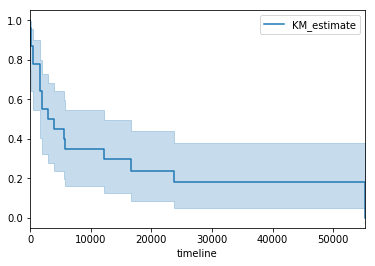

In [163]:
kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.plot_survival_function(); # or just kmf.plot()

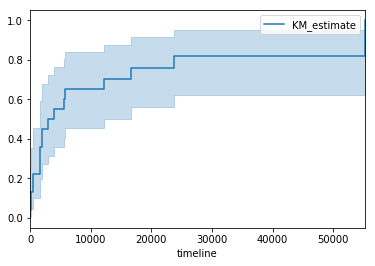

In [164]:
kmf.plot_cumulative_density();

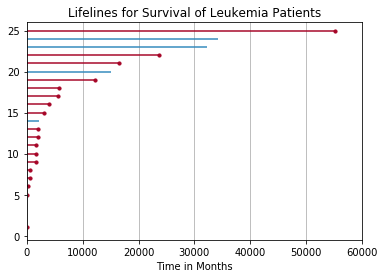

In [181]:
import lifelines
import matplotlib.pyplot as plt

durations = T
events = E

ax = lifelines.plotting.plot_lifetimes(durations=a.diff_in_sec.values,
                                       event_observed=a.observed.values)
ax.set_xlim(0, 60000)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Leukemia Patients");
plt.plot();

#### CoxPHFitter

In [222]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)

In [224]:
a.columns

Index(['advertiser_id', 'action_id', 'source_id', 'date', 'country_code',
       'latitude', 'longitude', 'wifi_connection', 'carrier_id', 'trans_id',
       'os_minor', 'agent_device', 'os_major', 'specs_brand', 'brand',
       'timeToClick', 'touchX', 'touchY', 'ref_type', 'ref_hash', 'source_csv',
       'application_id', 'click_hash', 'attributed', 'implicit',
       'device_countrycode', 'device_brand', 'device_model',
       'session_user_agent', 'user_agent', 'event_uuid', 'kind', 'wifi',
       'ip_address', 'device_language', 'index', 'event_id',
       'device_os_version', 'device_city', 'carrier', 'device_os',
       'connection_type', 'ref_type_id', 'diff_in_sec', 'observed'],
      dtype='object')

In [236]:
a.device_os.fillna('7.531669329342818e+18')

4133166     7.531669329342818e+18
38164052    7.531669329342818e+18
24638943    7.531669329342818e+18
41292132    7.531669329342818e+18
11761997    7.531669329342818e+18
3430037     7.531669329342818e+18
41248198    7.531669329342818e+18
38051047    7.531669329342818e+18
22152351    7.531669329342818e+18
126491      7.531669329342818e+18
32193270    7.531669329342818e+18
829931      7.531669329342818e+18
30635601    7.531669329342818e+18
22713922    7.531669329342818e+18
17080256    7.531669329342818e+18
7107004     7.531669329342818e+18
1339234     7.531669329342818e+18
9151597     7.531669329342818e+18
9101198     7.531669329342818e+18
26760610    7.531669329342818e+18
6749310     7.531669329342818e+18
466591      7.531669329342818e+18
3956471     7.531669329342818e+18
12181884    7.531669329342818e+18
2912361     7.531669329342818e+18
3956359     7.531669329342818e+18
Name: device_os, dtype: object

In [220]:
a[['wifi','observed','diff_in_sec']].fillna(False)

,wifi,observed,diff_in_sec
4133166,False,True,2010.799937
38164052,False,True,1660.348313
24638943,False,True,489.635776
41292132,False,True,216.475806
11761997,False,True,3948.721261
3430037,False,True,1564.336043
41248198,False,True,55226.622395
38051047,False,True,12260.588140
22152351,False,True,96.746177
126491,False,False,30.297152


In [223]:
cph.fit(a[['wifi','observed','diff_in_sec']].fillna(False), duration_col='diff_in_sec', event_col='observed', show_progress=True)
cph.print_summary()

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/1c2019/tp2/venv/lib/python3.5/site-packages/lifelines/utils/__init__.py:945: ConvergenceWarning: Column(s) ['wifi'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, ConvergenceWarning)


ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


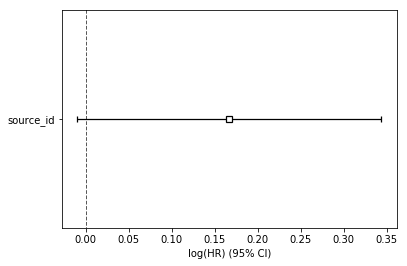

In [214]:
cph.plot();